In [2]:
from __future__ import print_function
import numpy as np
import h5py
import glob
import math
import os
import shutil
from scipy import signal
from scipy.signal import butter, lfilter
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from keras.layers import Bidirectional, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.optimizers import SGD, Adam
from keras import regularizers
from keras.engine.topology import Layer, InputSpec
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.initializers import VarianceScaling
from keras.callbacks import CSVLogger
from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')

# Loading the data

In [27]:
x = np.load('x.np.npy') # STFT of local and teleseismic waveforms
y = np.load('y.np.npy') # labels
n_clusters = 2

# Building the autoencoder

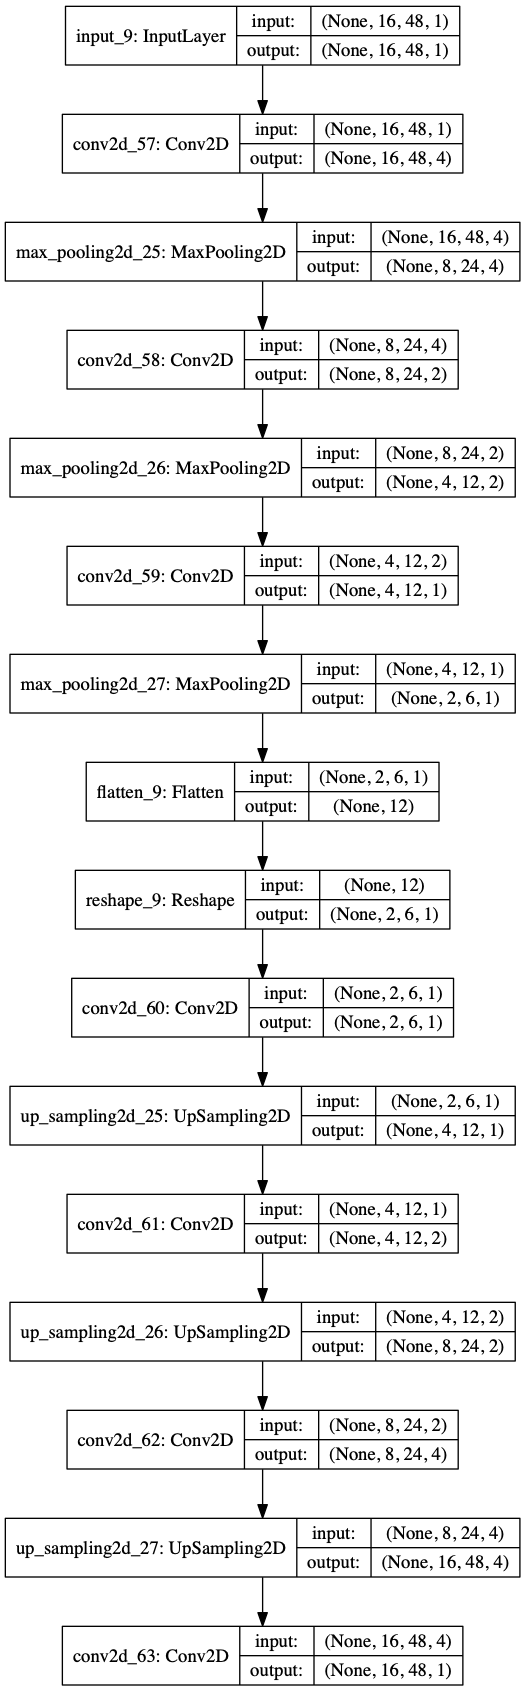

In [28]:
inp = Input(shape=(16, 48, 1))  
e = Conv2D(4, (3, 3), activation='tanh', padding='same')(inp)
e = MaxPooling2D((2, 2), padding='same')(e)
e = Conv2D(2, (3, 3), activation='tanh', padding='same')(e)
e = MaxPooling2D((2, 2), padding='same')(e)
e = Conv2D(1, (3, 3), activation='tanh', padding='same')(e)
e = MaxPooling2D((2, 2), padding='same')(e)

shape_before_flattening = K.int_shape(e)
encoded = Flatten()(e)
d = Reshape(shape_before_flattening[1:])(encoded)

d = Conv2D(1, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(2, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(4, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 2))(d)
decoded = Conv2D(1, (3, 3), padding='same')(d)

autoencoder = Model(inputs=inp, outputs=decoded, name='autoencoder')
encoder = Model(inputs=inp, outputs=encoded, name='encoder')
#autoencoder.summary()

from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

# Pretraining of the autoencoder

In [33]:
autoencoder.compile(optimizer='adam', loss='mse')
csv_logger = CSVLogger('pretrain_log.csv')

autoencoder.fit(x, x, batch_size=128, epochs=50, callbacks=[csv_logger])

Epoch 1/50
9200/9200 [==============================] - 8s 873us/step - loss: 0.0049
Epoch 2/50
9200/9200 [==============================] - 6s 673us/step - loss: 0.0048
Epoch 3/50
9200/9200 [==============================] - 6s 612us/step - loss: 0.0047
Epoch 4/50
9200/9200 [==============================] - 5s 584us/step - loss: 0.0046
Epoch 5/50
9200/9200 [==============================] - 6s 618us/step - loss: 0.0045
Epoch 6/50
9200/9200 [==============================] - 6s 606us/step - loss: 0.0043
Epoch 7/50
9200/9200 [==============================] - 5s 562us/step - loss: 0.0042
Epoch 8/50
9200/9200 [==============================] - 6s 627us/step - loss: 0.0041
Epoch 9/50
9200/9200 [==============================] - 6s 621us/step - loss: 0.0040
Epoch 10/50
9200/9200 [==============================] - 6s 623us/step - loss: 0.0039
Epoch 11/50
9200/9200 [==============================] - 6s 639us/step - loss: 0.0039
Epoch 12/50
9200/9200 [==============================] - 6s 624

# Now, adding the clustering layer into the bottelneck layer 

...Finetuning...


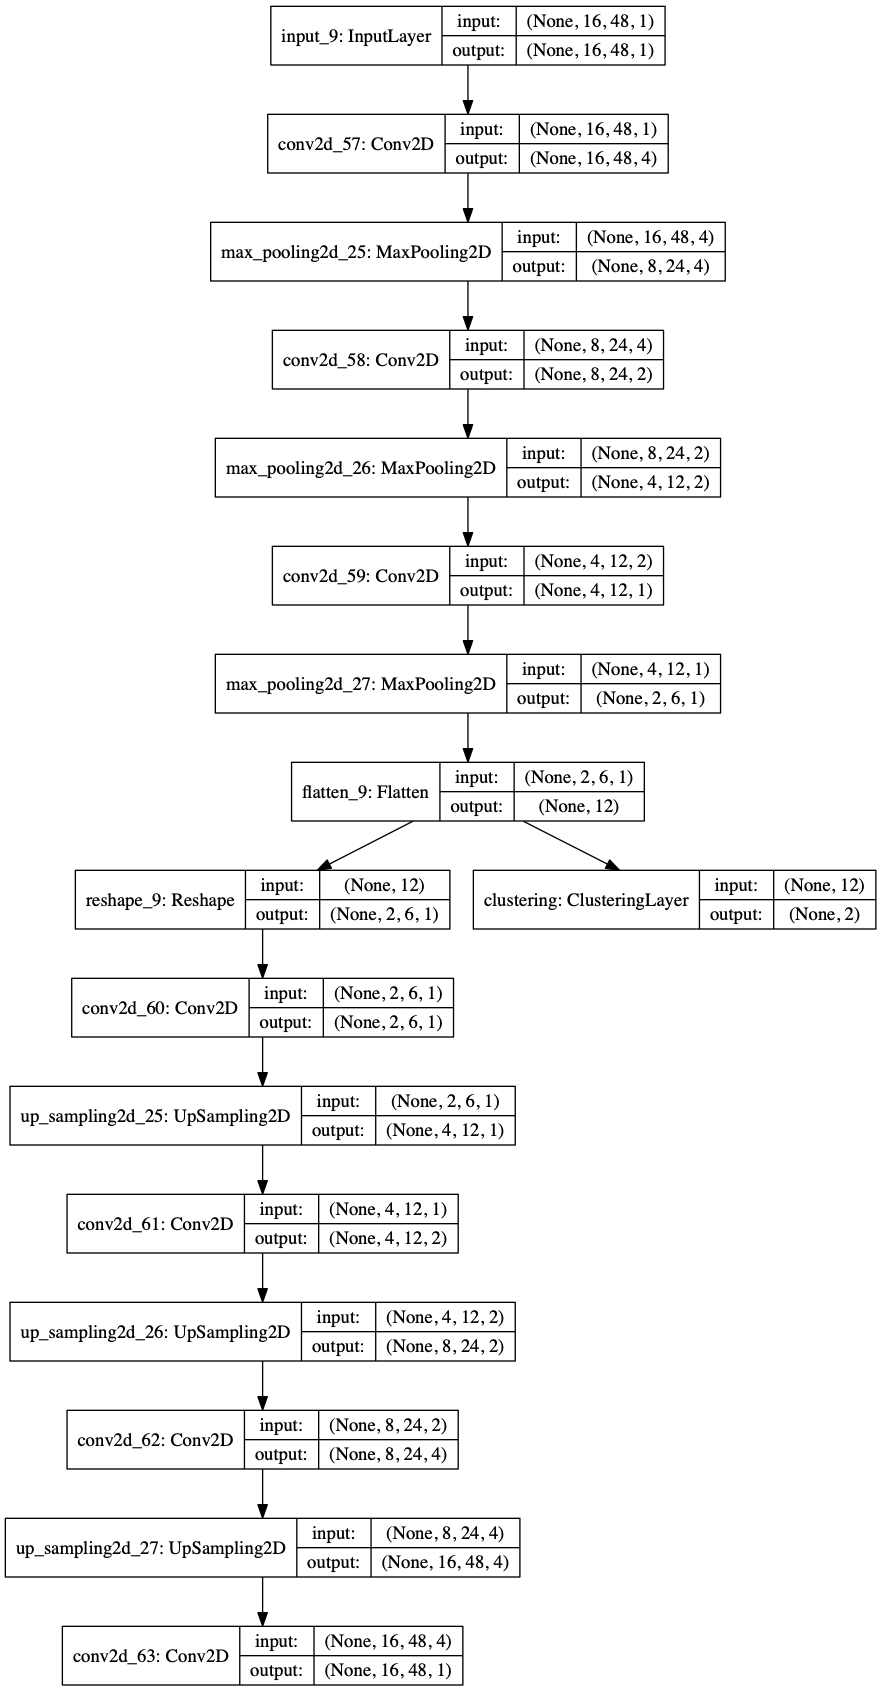

In [34]:
#### clustering layers
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) 
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
print('...Finetuning...')   
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

# Finetuning of full network

In [35]:
### initializing the weights using Kmean and assigning them to the model
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
   
np.round(metrics.acc(y, y_pred), 5)

0.89011

In [36]:
## parameters for the finetuning
batch_size=256
tol = 0.001 # tolerance threshold to stop training
loss = 0
index = 0
maxiter =5000
update_interval = 150
index_array = np.arange(x.shape[0])

###############################################################################
### simultaneous optimization and clustering
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p       
        y_pred = q.argmax(1) # evaluate the clustering performance

        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f' % (ite, acc), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)

        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            break
        
        IN = encoder.predict(x)        
    
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0  


Iter 0: acc = 0.89011  ; loss= 0
Iter 150: acc = 0.92674  ; loss= [0.00255 0.00026 0.00252]
Iter 300: acc = 0.93239  ; loss= [0.00274 0.00176 0.00256]
Iter 450: acc = 0.93467  ; loss= [0.00398 0.01069 0.00291]
Iter 600: acc = 0.94033  ; loss= [0.01036 0.05593 0.00477]
Iter 750: acc = 0.95946  ; loss= [0.00925 0.03976 0.00527]
Iter 900: acc = 0.96033  ; loss= [0.00948 0.04917 0.00456]
Iter 1050: acc = 0.95761  ; loss= [0.00927 0.05899 0.00337]
Iter 1200: acc = 0.97011  ; loss= [0.00811 0.04944 0.00317]
Iter 1350: acc = 0.97880  ; loss= [0.00853 0.05234 0.00329]
Iter 1500: acc = 0.98022  ; loss= [0.0132  0.07967 0.00524]
Iter 1650: acc = 0.98391  ; loss= [0.01114 0.06033 0.00511]
Iter 1800: acc = 0.98174  ; loss= [0.01107 0.06451 0.00462]
Iter 1950: acc = 0.98098  ; loss= [0.00937 0.05826 0.00354]
Iter 2100: acc = 0.98272  ; loss= [0.00769 0.04396 0.0033 ]
Iter 2250: acc = 0.98478  ; loss= [0.00812 0.04609 0.00351]
Iter 2400: acc = 0.98326  ; loss= [0.01173 0.06812 0.00492]
Iter 2550: ac

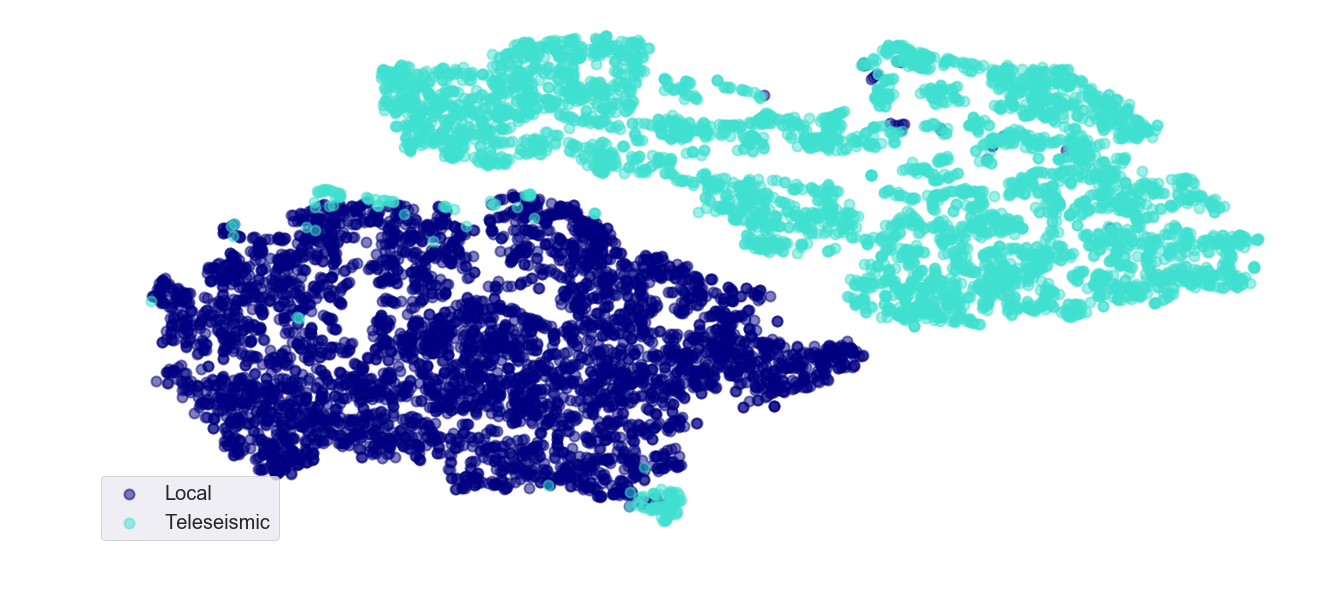

(<Figure size 1584x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12ecfa7b8>)

In [39]:
def plotter(S, y, target_names):
    '''
    function to visualize the outputs of t-SNE
    '''
    # choose a color palette with seaborn.
    colors = ['navy', 'turquoise', 'darkorange']
    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    for color, i, target_name in zip(colors, [0, 1], target_names):
        plt.scatter(S[y == i, 0], S[y == i, 1], color=color, alpha=.5, lw=lw, s=100, label=target_name)
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, prop={'size': 20})
    ax.axis('off')
    ax.axis('tight') 
    plt.show()

    return f, ax

enc = encoder.predict(x)
from sklearn.manifold import TSNE
redu = TSNE(random_state=123).fit_transform(enc)
target_names = ['Local', 'Teleseismic']
plotter(redu, y, target_names) 


## Plotting the embedded layer 

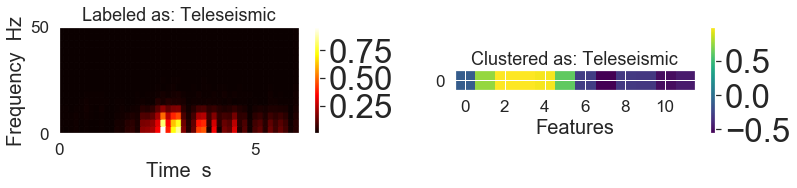

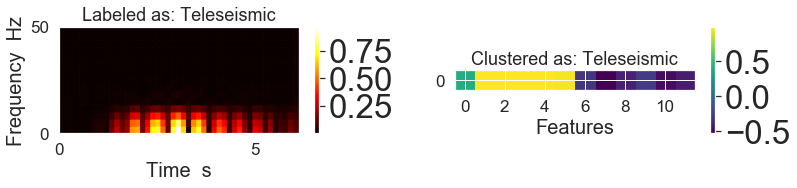

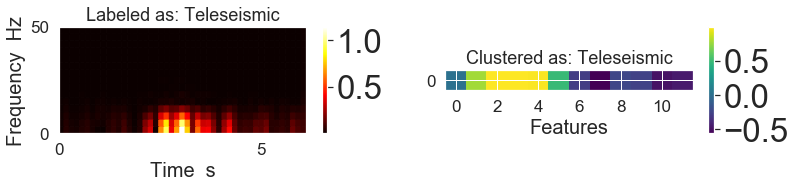

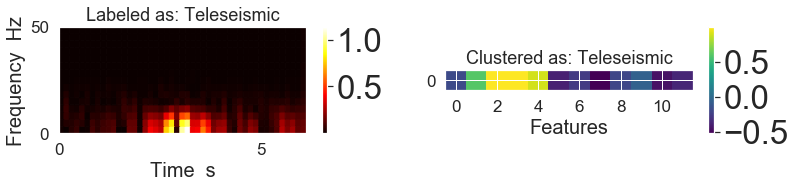

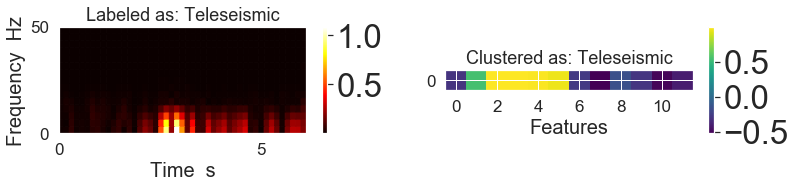

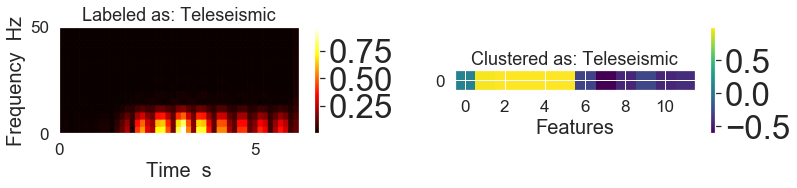

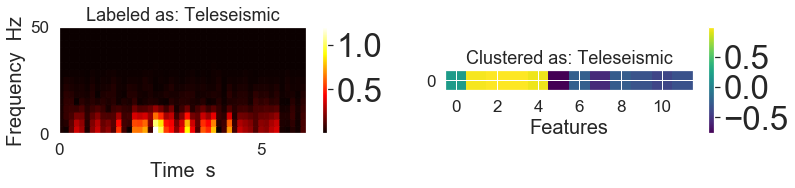

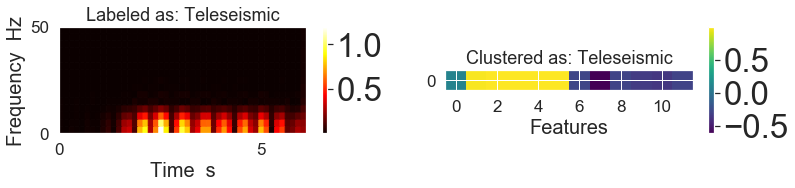

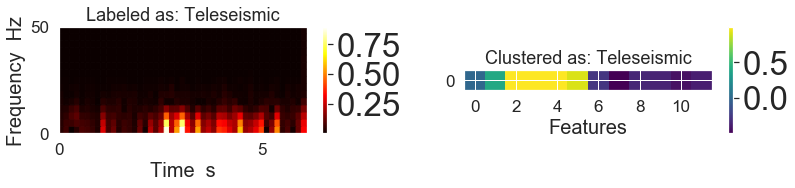

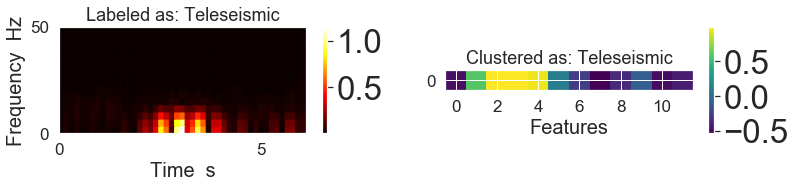

In [41]:
q, _  = model.predict(x, verbose=0)
y_pred = q.argmax(1)
enc = encoder.predict(x)
t = np.load('t.npy')
f = np.load('f.npy')

for i in range(7000, 7010, 1):    
    
    if y_pred[i] == 1. and y[i] == 1.:
        
        fig = plt.figure(figsize=(12, 3.5))     
        ax = fig.add_subplot(121)    
        plt.pcolormesh(t, f, x[i, :, :, 0], alpha=None, cmap='hot', shading='flat', antialiased=True)
        plt.ylabel('Frequency  Hz',  fontsize=20)
        plt.xlabel('Time  s', fontsize=20)
        plt.yticks(fontsize=17)
        plt.xticks(fontsize=17)
        plt.colorbar()
       
        if y[i] == 0.0:
            plt.title('Labeled as: Local', fontsize=18)
        else:
            plt.title('Labeled as: Teleseismic', fontsize=18)   
     
        ax = fig.add_subplot(122)
        plt.imshow(enc[i].reshape(1, 12), cmap='viridis')
        plt.xlabel('Features', fontsize=20)
        plt.yticks(np.arange(0, 1, step=1), fontsize=17)
        plt.xticks(np.arange(0, 12, step=2), fontsize=17)
        plt.colorbar()

        if y_pred[i] == 0:
            plt.title('Clustered as: Local', fontsize=18)
        else:
            plt.title('Clustered as: Teleseismic', fontsize=18)
        fig.tight_layout()
        plt.show()

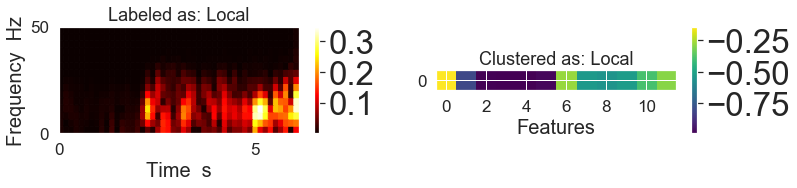

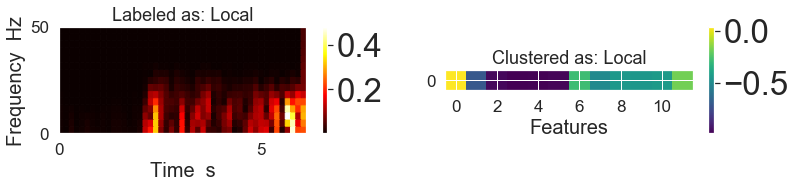

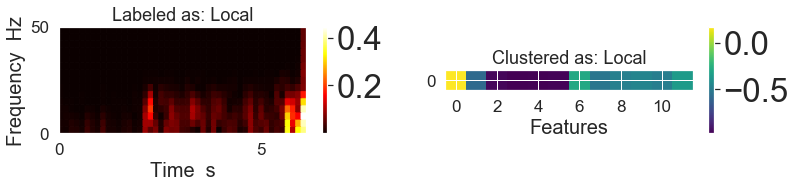

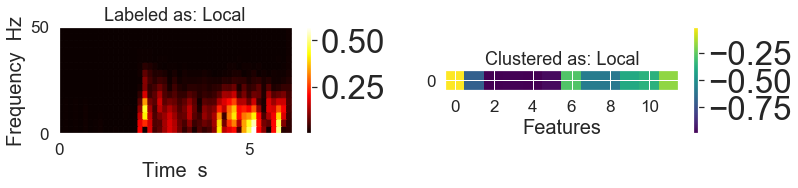

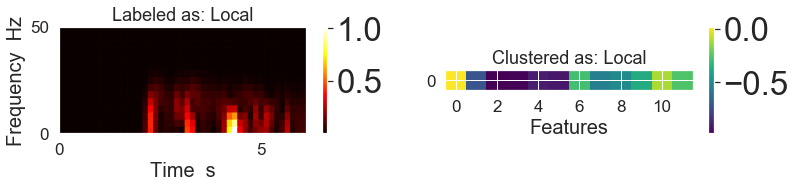

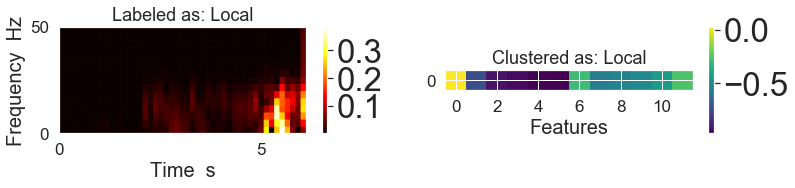

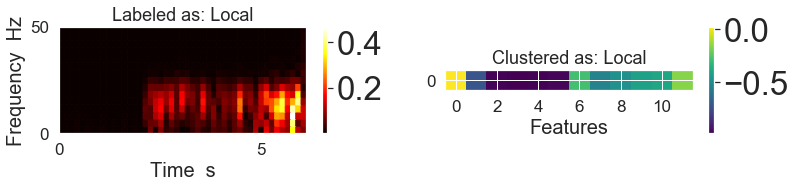

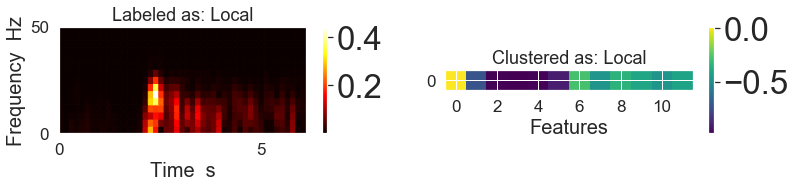

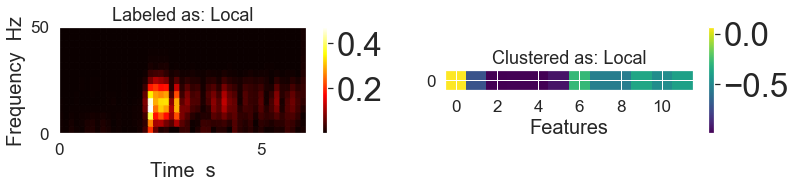

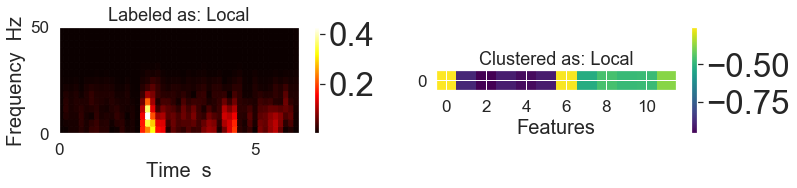

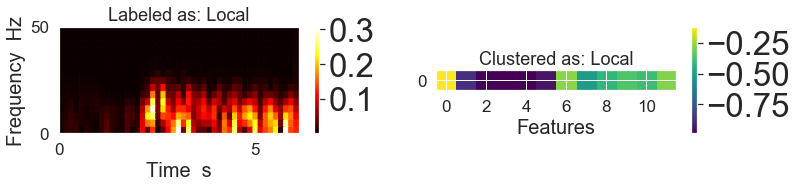

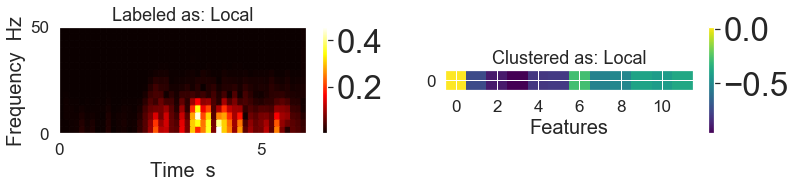

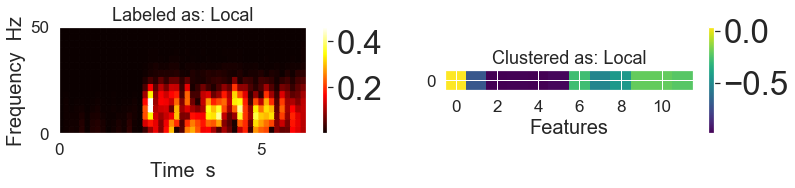

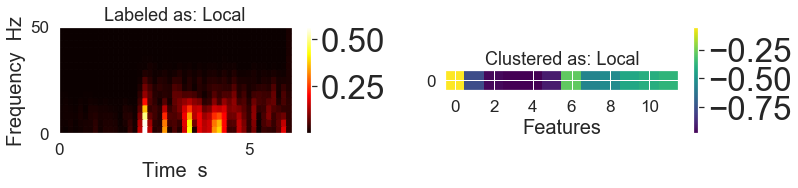

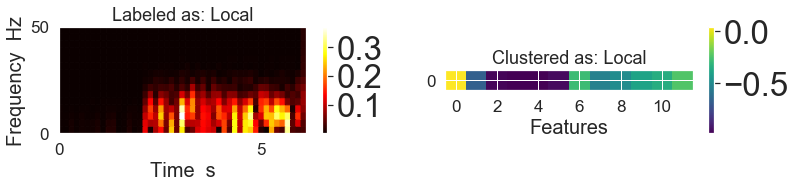

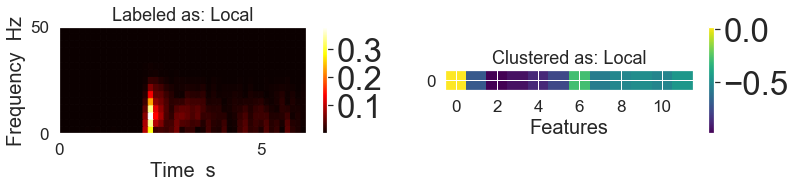

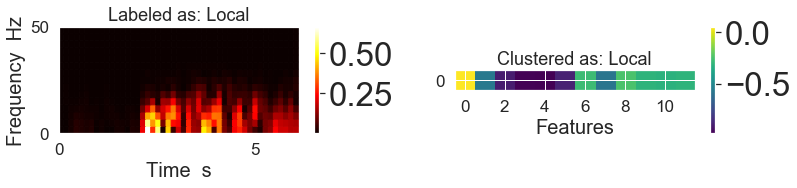

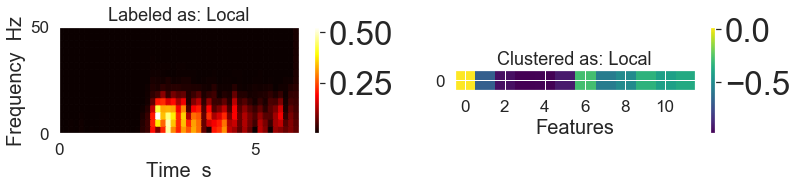

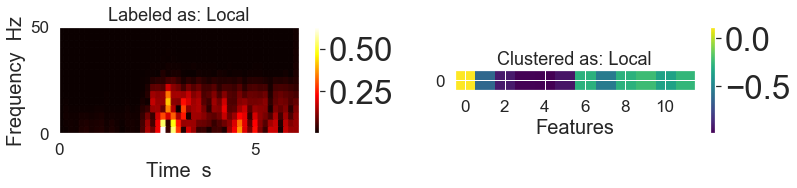

In [54]:
q, _  = model.predict(x, verbose=0)
y_pred = q.argmax(1)
enc = encoder.predict(x)
t = np.load('t.npy')
f = np.load('f.npy')

for i in range(1, 20, 1):    
    
    if y_pred[i] == 0. and y[i] == 0.:
        
        fig = plt.figure(figsize=(12, 3.5))     
        ax = fig.add_subplot(121)    
        plt.pcolormesh(t, f, x[i, :, :, 0], alpha=None, cmap='hot', shading='flat', antialiased=True)
        plt.ylabel('Frequency  Hz',  fontsize=20)
        plt.xlabel('Time  s', fontsize=20)
        plt.yticks(fontsize=17)
        plt.xticks(fontsize=17)
        plt.colorbar()
       
        if y[i] == 0.0:
            plt.title('Labeled as: Local', fontsize=18)
        else:
            plt.title('Labeled as: Teleseismic', fontsize=18)   
     
        ax = fig.add_subplot(122)
        plt.imshow(enc[i].reshape(1, 12), cmap='viridis')
        plt.xlabel('Features', fontsize=20)
        plt.yticks(np.arange(0, 1, step=1), fontsize=17)
        plt.xticks(np.arange(0, 12, step=2), fontsize=17)
        plt.colorbar()

        if y_pred[i] == 0:
            plt.title('Clustered as: Local', fontsize=18)
        else:
            plt.title('Clustered as: Teleseismic', fontsize=18)
        fig.tight_layout()
        plt.show()        